In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
import torch
import torch.nn as nn
import librosa
import scipy
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import IPython.display as ipd

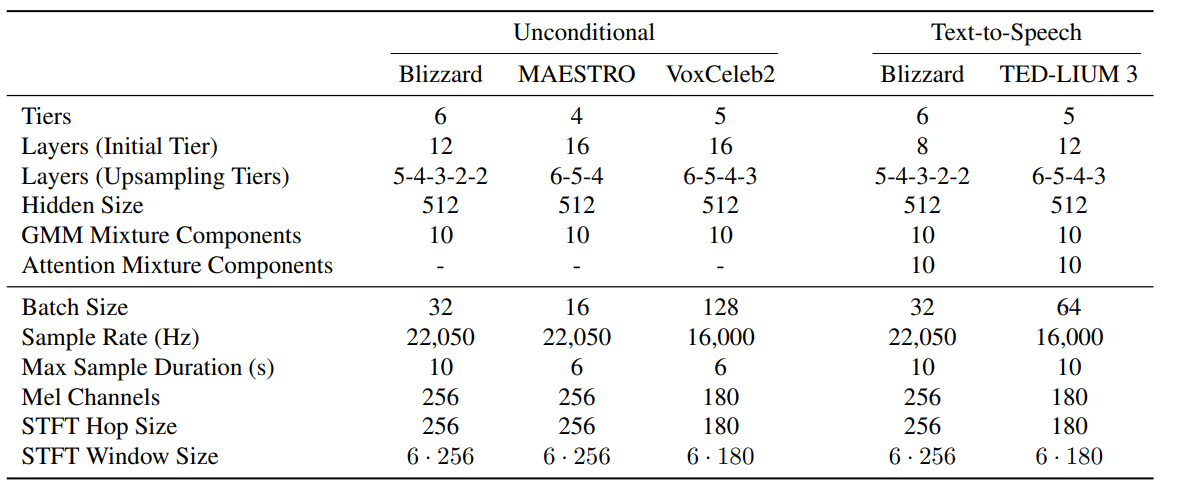

# Melnet Hyperparameters
- RNN - LSTM 
- optimizer: RMSProb
    - learning_rate: 1e-4
    - momentum: 0.9
    - recurrent_states: trainable parameters
    - hidden_size: 512 
        - (RNN state size, residual connection, embeddings)
    - initial_tier
        - text, speaker ID에 의해 conditioned (only)
        - centralized stack (only)
            - attention cell is used in the centralized stack. it is inserted in the middle layer (L/2)        

In [ ]:
# hyperparameters
nsc = 6 * 256
hop_size = 256
nov = nsc - hop_size
mel_channels = 256
hidden_size = 512
fs = 22050
K = 10 # Gaussian Mixture Components

mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=mel_channels)
print(mel_filters.shape)

(256, 769)


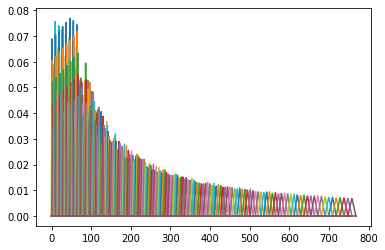

In [ ]:
plt.plot(mel_filters.T) # (193, 256)
plt.show()

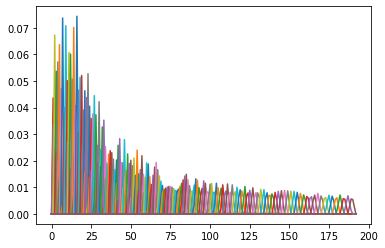

In [ ]:
plt.plot(mel_filters.T[::4])
plt.show()

In [ ]:
audio_path = '/content/MyDrive/MyDrive/[해커톤]DeepASMR/temp/0.wav'

In [ ]:
y, fs = librosa.core.load(audio_path)

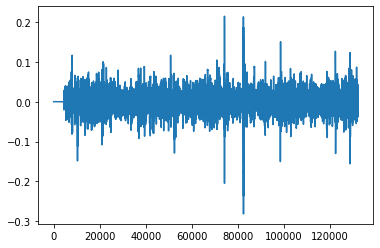

In [ ]:
plt.plot(y)
plt.show()
ipd.Audio(y, rate=fs)

In [ ]:
f, t, Sxx = scipy.signal.stft(y, fs=fs, window='hann', nperseg=nsc, noverlap=nov)
# Sxx = Sxx[1:, :]
Zxx = np.abs(Sxx)
log_spectrogram = 20 * np.log10(np.maximum(Zxx, 1e-8))
log_spectrogram_norm = (log_spectrogram + 160) / 160

mel_spectrogram = np.matmul(mel_filters, Zxx)
log_mel_spectrogram = 20 * np.log10(np.maximum(mel_spectrogram, 1e-8))
mel_input = (log_mel_spectrogram + 160) / 160

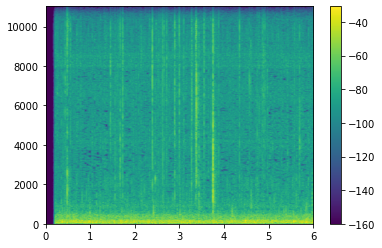

(769, 518)


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.imshow(log_spectrogram, origin='reverse', extent=[0, t[-1], 0, f[-1]])
plt.colorbar()

# plt.ylim([0, 200])
ax.set_aspect('auto')

plt.show()

print(log_spectrogram.shape)

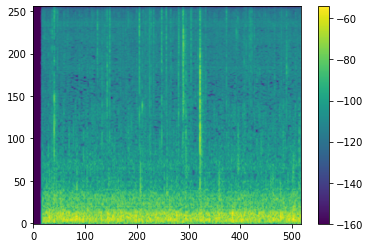

(256, 518)


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.imshow(log_mel_spectrogram, origin='reverse')
plt.colorbar()

# plt.ylim([0, 200])
ax.set_aspect('auto')

plt.show()

print(mel_input.shape)

In [ ]:
mel_input

Tier6 = mel_input[::2, :]
Tier6_not = mel_input[1::2, :]

Tier5 = Tier6_not[:, ::2]
Tier5_not = Tier6_not[:, 1::2]

Tier4 = Tier5_not[::2, :]
Tier4_not = Tier5_not[1::2, :]

Tier3 = Tier4_not[:, ::2]
Tier3_not = Tier4_not[:, 1::2]

Tier2 = Tier3_not[::2, :]
Tier1 = Tier3_not[1::2, :]

Tiers = [Tier1, Tier2, Tier3, Tier4, Tier5, Tier6]


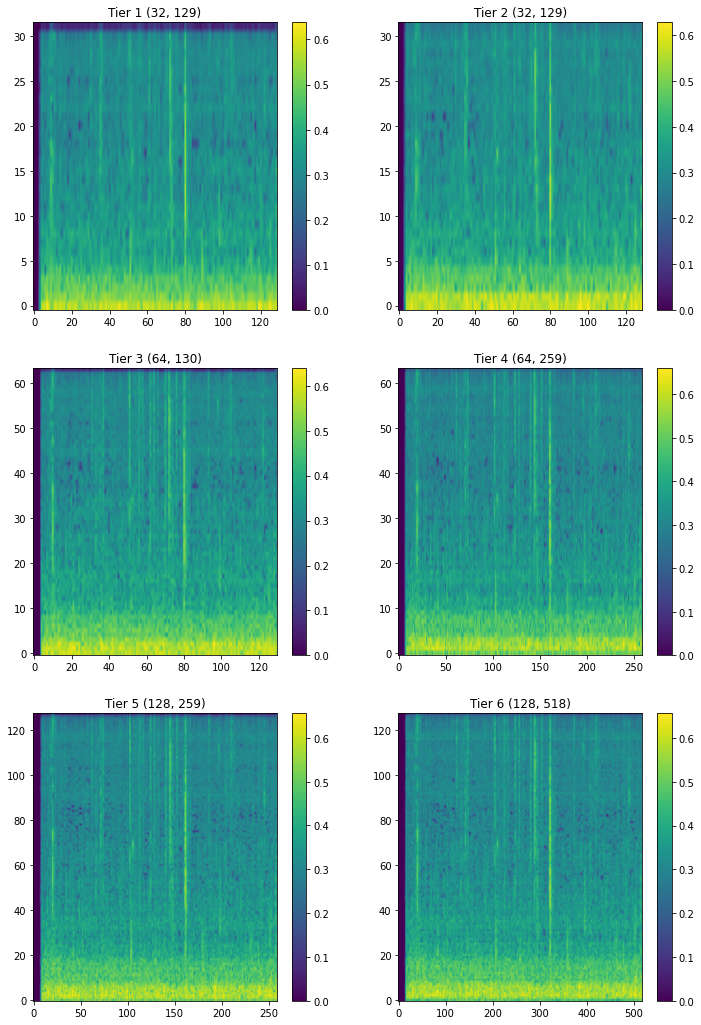

In [ ]:
fig = plt.figure(figsize=(12, 18))

for i in range(0, 6):
    ax = fig.add_subplot(3, 2, i + 1)

    plt.imshow(Tiers[i], origin='reverse')
    plt.colorbar()
    
    ax.set_aspect('auto')
    ax.title.set_text('Tier {} {}'.format(i + 1, Tiers[i].shape))

plt.show()

In [ ]:
tensor = torch.tensor(Tier1.T)

In [ ]:
input_tensor = tensor.view([1, tensor.shape[0], tensor.shape[1], 1])

In [ ]:
input_tensor.shape

torch.Size([1, 129, 32, 1])

In [ ]:
input_tensor[:, :, :, 0].shape

torch.Size([1, 129, 32])

In [ ]:
W_f_0 = nn.Linear(1, hidden_size)
W_t_0 = nn.Linear(1, hidden_size)
W_c_0 = nn.Linear(32, hidden_size)

In [ ]:
h_f_0_ = W_f_0(input_tensor)
h_f_0 = torch.zeros(h_f_0_.shape)
h_f_0[:, :, 1:, :] = h_f_0_[:, :, :-1, :]
print('h_f_0: {}'.format(h_f_0.shape))

h_f_0: torch.Size([1, 129, 32, 512])


In [ ]:
h_t_0_ = W_t_0(input_tensor)
h_t_0 = torch.zeros(h_t_0_.shape)
h_t_0[:, 1:, :, :] = h_t_0_[:, :-1, :, :]
print('h_t_0: {}'.format(h_t_0.shape))

h_t_0: torch.Size([1, 129, 32, 512])


In [ ]:
h_c_0_ = W_c_0(input_tensor[:, :, :, 0])
h_c_0 = torch.zeros(h_c_0_.shape)
h_c_0[:, 1:, :] = h_c_0_[:, :-1, :]
print('h_c_0: {}'.format(h_c_0.shape))

h_c_0: torch.Size([1, 129, 512])


In [ ]:
time_delayed_RNN_x = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
time_delayed_RNN_y = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
time_delayed_RNN_z = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

W_t_1 = nn.Linear(3 * hidden_size, hidden_size)

centralized_RNN = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

W_c_1 = nn.Linear(hidden_size, hidden_size)

frequency_delayed_RNN = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

W_f_1 = nn.Linear(hidden_size, hidden_size)

In [ ]:
outputs_x = list()

for i in range(h_t_0.shape[2]):
    output_x, _ = time_delayed_RNN_x(h_t_0[:, :, i, :])
    outputs_x.append(output_x)
    
h_t_1_x = torch.stack(outputs_x, 2)
print('h_t_1_x: {}'.format(h_t_1_x.shape))

outputs_y = list()
outputs_z = list()

for i in range(h_t_0.shape[1]):
    reverse_index = np.arange(h_t_0.shape[2] - 1, -1, -1)
    output_y, _ = time_delayed_RNN_y(h_t_0[:, i, :, :])
    output_z, _ = time_delayed_RNN_z(h_t_0[:, i, reverse_index, :])
    outputs_y.append(output_y)
    outputs_z.append(output_z[:, reverse_index, :])
    
h_t_1_y = torch.stack(outputs_y, 1)
h_t_1_z = torch.stack(outputs_z, 1)
print('h_t_1_y: {}'.format(h_t_1_y.shape))
print('h_t_1_z: {}'.format(h_t_1_z.shape))

h_t_1_x: torch.Size([1, 129, 32, 512])
h_t_1_y: torch.Size([1, 129, 32, 512])
h_t_1_z: torch.Size([1, 129, 32, 512])


In [ ]:
h_t_1_ = torch.cat([h_t_1_x, h_t_1_y, h_t_1_z], 3)
print('h_t_1_: {}'.format(h_t_1_.shape))

h_t_1_w = W_t_1(h_t_1_)
print('h_t_1_w: {}'.format(h_t_1_w.shape))

h_t_1 = torch.add(h_t_1_w, h_t_0)
print('h_t_1: {}'.format(h_t_1.shape))

h_t_1_: torch.Size([1, 129, 32, 1536])
h_t_1_w: torch.Size([1, 129, 32, 512])
h_t_1: torch.Size([1, 129, 32, 512])


In [ ]:
h_c_1_, _ = centralized_RNN(h_c_0)
print('h_c_1_: {}'.format(h_c_1_.shape))

h_c_1_w = W_c_1(h_c_1_)
print('h_c_1_w: {}'.format(h_c_1_w.shape))

h_c_1 = h_c_1_w + h_c_0
print('h_c_1: {}'.format(h_c_1.shape))

h_c_1_: torch.Size([1, 129, 512])
h_c_1_w: torch.Size([1, 129, 512])
h_c_1: torch.Size([1, 129, 512])


In [ ]:
h_c_1_expand = h_c_1.view(h_c_1.shape[0], h_c_1.shape[1], 1, h_c_1.shape[2]).repeat(1, 1, 32, 1)
print('h_c_1_expand: {}'.format(h_c_1_expand.shape))

h_f_1_sum = torch.add(torch.add(h_f_0, h_t_1), h_c_1_expand)
print('h_f_1_sum: {}'.format(h_f_1_sum.shape))

outputs = list()

for i in range(h_f_1_sum.shape[1]):
    output, _ = frequency_delayed_RNN(h_f_1_sum[:, i, :, :])
    outputs.append(output)
    
h_f_1_ = torch.stack(outputs, 1)
print('h_f_1_: {}'.format(h_f_1_.shape))

h_f_1_w = W_f_1(h_f_1_)
print('h_f_1_w: {}'.format(h_f_1_w.shape))

h_f_1 = torch.add(h_f_1_w, h_f_0)
print('h_f_1: {}'.format(h_f_1.shape))

h_c_1_expand: torch.Size([1, 129, 32, 512])
h_f_1_sum: torch.Size([1, 129, 32, 512])
h_f_1_: torch.Size([1, 129, 32, 512])
h_f_1_w: torch.Size([1, 129, 32, 512])
h_f_1: torch.Size([1, 129, 32, 512])


In [ ]:
W_theta = nn.Linear(hidden_size, 3 * K)

theta_hat = W_theta(h_f_1)
print('theta_hat: {}'.format(theta_hat.shape))

theta_hat: torch.Size([1, 129, 32, 30])


In [ ]:
mu = theta_hat[:, :, :, :K]
std = torch.exp(theta_hat[:, :, :, K:2*K])
pi_softmax = nn.Softmax(dim=3)
pi = pi_softmax(theta_hat[:, :, :, 2*K:])

In [ ]:
sum(pi[0, 53, 18, :])

tensor(1.0000, grad_fn=<AddBackward0>)

In [ ]:
loss = torch.zeros(input_tensor[:, :, :, 0].shape)
print('loss: {}'.format(loss.shape))

for batch in range(loss.shape[0]):
    for i in range(loss.shape[1]):
        for j in range(loss.shape[2]):
            prob = 0
            
            for k in range(K):
                prob += pi[batch, i, j, k] * torch.exp(torch.distributions.normal.Normal(mu[batch, i, j, k], std[batch, i, j, k]).log_prob(input_tensor[batch, i, j, 0]))
            
            loss[batch, i, j] = - torch.log(prob)

loss: torch.Size([1, 129, 32])


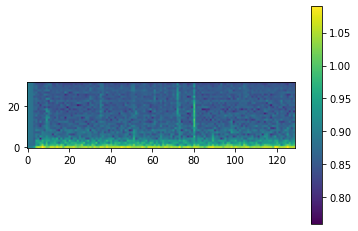

In [ ]:
plt.imshow(loss[0, :, :].detach().numpy().T, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
M = loss[0, :, :].detach().numpy()

In [ ]:
# Reconstruction

In [ ]:
S = librosa.feature.inverse.mel_to_stft(M)
y = librosa.griffinlim(S)

In [ ]:
ipd.Audio(y, rate=fs)